In [2]:
import os
import re

# Adjust these paths if necessary
ITEMS_LUA_PATH = r"C:\FXServer\txData\QBCoreFramework_5784FC.base\resources\[qb]\qb-core\shared\items.lua"
IMAGES_FOLDER = r"C:\FXServer\txData\QBCoreFramework_5784FC.base\resources\[qb]\qb-inventory\html\images"

# Regex to capture the filename from lines like: image = 'weapon_bat.png',
pattern = r"image\s*=\s*'([^']+)'"

missing_images = []

# 1. Read the entire items.lua
with open(ITEMS_LUA_PATH, "r", encoding="utf-8") as f:
    content = f.read()

# 2. Find all "image = 'filename.ext'" occurrences
matches = re.findall(pattern, content)

# 3. For each image name, check if it exists in the images folder
for image_name in matches:
    image_path = os.path.join(IMAGES_FOLDER, image_name)
    if not os.path.exists(image_path):
        missing_images.append(image_name)

# 4. Print the results
print("\n=== Missing Images ===")
if missing_images:
    for img in missing_images:
        print(f" - {img}")
    print(f"\nTotal missing images: {len(missing_images)}")
else:
    print("No missing images! All good.")




=== Missing Images ===
 - placeholder.png
 - weapon_candycane
 - luxuryfinish_attachment.png
 - xtc_brick.png
 - oxy_brick.png
 - meth_brick.png
 - weed.png
 - coke_seed.png
 - dmt_seed.png
 - poppy_seed.png
 - potato_seed.png
 - carrot_seed.png
 - wheat_seed.png
 - tomato_seed.png
 - crafting_table_bad.png
 - crafting_table_normal.png
 - crafting_table_good.png
 - crafting_general_station.png
 - steelingot.png
 - highentropyalloyingot.png
 - weapon_dildo.png
 - explosivecharge.png
 - hydraulicspreader.png

Total missing images: 23


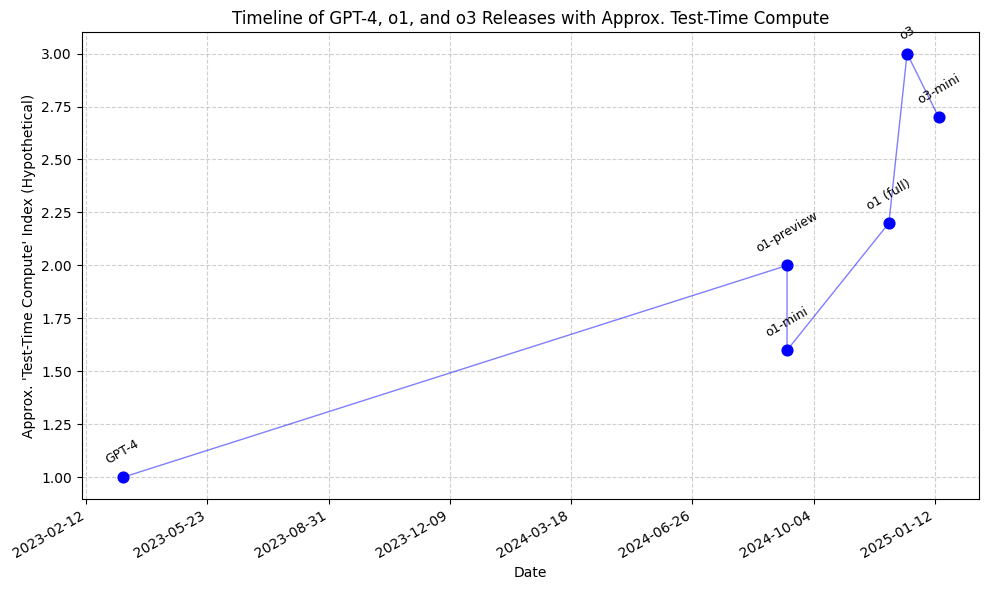

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from matplotlib.dates import date2num

# --- 1. Define the data (dates & approximate "test-time compute" indexes) ---
# Format: (label, date, compute_index)
model_data = [
    ("GPT-4",       datetime(2023, 3, 14), 1.0),
    ("o1-preview",  datetime(2024, 9, 12), 2.0),
    ("o1-mini",     datetime(2024, 9, 12), 1.6),
    ("o1 (full)",   datetime(2024, 12, 5), 2.2),
    ("o3",          datetime(2024, 12, 20), 3.0),
    # For o3-mini, let's pick a mid-January date, as "January 2025" is mentioned
    ("o3-mini",     datetime(2025, 1, 15), 2.7),
]

# Sort data by date just to be safe
model_data.sort(key=lambda x: x[1])

# --- 2. Convert datetime to a numeric format for plotting ---
x_dates = [date2num(m[1]) for m in model_data]
y_compute = [m[2] for m in model_data]
labels = [m[0] for m in model_data]

# --- 3. Create the plot ---
plt.figure(figsize=(10, 6))

# Scatter plot: X is the date, Y is the approximate compute index
plt.scatter(x_dates, y_compute, color='blue', s=60, zorder=3)

# Connect the dots with a line to show progression over time
plt.plot(x_dates, y_compute, color='blue', linewidth=1, alpha=0.5, zorder=2)

# Label each point
for i, txt in enumerate(labels):
    plt.text(
        x_dates[i],
        y_compute[i] + 0.05,  # small vertical offset
        txt,
        ha='center',
        va='bottom',
        fontsize=9,
        rotation=30
    )

# Format the X-axis to show dates nicely
plt.title("Timeline of GPT-4, o1, and o3 Releases with Approx. Test-Time Compute")
plt.xlabel("Date")
plt.ylabel("Approx. 'Test-Time Compute' Index (Hypothetical)")
plt.grid(True, linestyle='--', alpha=0.6)

# Use auto-formatting for date labels
import matplotlib.dates as mdates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()
